In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

## Reading and Cleaning the Data

Read the csv and take a look at the head of the data.

In [2]:
Survey=pd.read_csv('Wellness Survey Responses.csv')
Survey.head()

,Timestamp,1. I am happy.,2. I am preoccupied with more than one person I help.,3. I get satisfaction from being able to help people.,4.I feel connected to others.,5. I jump or am startled by unexpected sounds.,6.I feel invigorated after working with those I help.,7. I find it difficult to separate my personal life from my life as a helper.,8. I am not as productive at work because I am losing sleep over traumatic experiences of a person I help.,9. I think that I might have been affected by the traumatic stress of those I help.,...,This school cares about student wellbeing.,Teachers and students generally have good relationships in this school.,Staff generally have good relationships with each other in this school.,What do you love about your role?,How do you cope with stress?,How do you feel about the supports in place for staff at Tri-County?,Do you take an uninterrupted lunch everyday?,Do you work outside of your scheduled hours?,"What could be improved, if anything, to make you feel more supported in your role?",Any relevant information regarding staff wellness and support can be added here:
0,12/6/2023 21:20:54,Sometimes,Very Often,Very Often,Rarely,Never,Very Often,Very Often,Rarely,Sometimes,...,Agree,Agree,Agree,"Helping others, ah ha moments, growing skills",Not well,Not aware of,No,Yes,Time for access to admin and other available s...,Open to whatever relevant initiatives that can...
1,12/6/2023 21:40:08,Sometimes,Often,Often,Very Often,Sometimes,NaN,Sometimes,Sometimes,Rarely,...,Agree,Strongly agree,Agree,Helping students,Exercise,Not much available,No,Yes,NaN,NaN
2,12/6/2023 22:48:52,Often,Sometimes,Sometimes,Sometimes,Very Often,Sometimes,Sometimes,Sometimes,Often,...,Disagree,Disagree,Agree,NaN,NaN,Supports?,No,Yes,Administrators who actually trust that I am a ...,NaN
3,12/6/2023 22:54:57,Often,Often,Sometimes,Often,Sometimes,Sometimes,Sometimes,Sometimes,Sometimes,...,Agree,Agree,Agree,Teaching and watching students grow,"Exercise, weekends",I’m not aware of any of the supports currently...,No,"Yes, often",I’m not sure. What do other high schools do?,Our work is very intense. The expectations are...
4,12/7/2023 6:10:16,Often,Rarely,Sometimes,Sometimes,Rarely,Sometimes,Sometimes,Sometimes,Sometimes,...,Agree,Agree,Agree,Relationships with staff and students,Exercise,Meh,Yes,Yes,NaN,NaN


Several of the questions from this survey come from the PROQOL (professional quality of life) survey, and my goal here is to translate the responses into numerical values so they may be scored according to the documentation. We're looking at just the columns to check which columns that survey occupies, and whether there is other data.

In [3]:
Survey.columns

Index(['Timestamp', '1. I am happy. ',
       '2. I am preoccupied with more than one person I help. ',
       '3. I get satisfaction from being able to help people.',
       '4.I feel connected to others.',
       '5. I jump or am startled by unexpected sounds.',
       '6.I feel invigorated after working with those I help.',
       '7. I find it difficult to separate my personal life from my life as a helper. ',
       '8. I am not as productive at work because I am losing sleep over traumatic experiences of a person I help.',
       '9. I think that I might have been affected by the traumatic stress of those I help.',
       '10. I feel trapped by my job as a helper. ',
       '11.Because of my helping, I have felt "on edge" about various things.',
       '12.I like my work as a helper. ',
       '13. I feel depressed because of the traumatic experiences of the people I help. ',
       ' 14.I feel as though I am experiencing the trauma of someone I have helped.',
       '15. I have 

I don't need the timestamp column, so I'm going to drop that for now.

In [4]:
Survey.drop(columns=['Timestamp'], inplace=True)

The PROQOL documentation specifies values for each response in the survey, and it also specifies that the scores get reveresed for some of the responses. So here we map the correct scores to the correct responses in the dataframe.

In [5]:
# mapping responses to numerical values
words_score={'Never' : 1, 'Rarely' : 2, 'Sometimes' : 3, 'Often' : 4, 'Very Often' : 5}
Survey.replace(words_score, inplace=True)
reversals={1 : 5, 2 : 4, 4: 2, 5 : 1}
# reversing the values of certain columns as specified by PROQOL documentation
reversal_columns=Survey.columns[[0,3,14,16,28]]
Survey[reversal_columns]=Survey[reversal_columns].replace(reversals)

The questions in the PROQOL survey are broken up into three categories: compassion satisfaction, burnout, and secondary traumatic stress. Scores are assigned to each category by summing up the values of responses to the corresponding questions. So here, we're obtaining the compassion satisfaction, burnout, and secondary traumatic stress scores for each respondent.

In [6]:
# Split the columns the correspond to the PROQOL into their distinct categories
proqol_cols=Survey.columns[0:30]
compassion=proqol_cols[[2, 5, 11, 15, 17, 19, 21, 23, 26, 29]]
burnout=proqol_cols[[0, 3, 7, 9, 14, 16, 18, 20, 25, 28]]
sts=proqol_cols[[1, 4, 6, 8, 10, 12, 13, 22, 24, 27]]

In [7]:
# create lists of scores for each category
sts_score, compassion_score, burnout_score=[], [], []
for n in range(0,len(Survey.index)):
    s_score=Survey.loc[n][sts].sum()
    sts_score.append(s_score)

for n in range(0,len(Survey.index)):
    c_score=Survey.loc[n][compassion].sum()
    compassion_score.append(c_score)

for n in range(0,len(Survey.index)):
    b_score=Survey.loc[n][burnout].sum()
    burnout_score.append(b_score)

In [8]:
# create a dataframe from the composite score lists
score_dict={'Compassion Satisfaction' : compassion_score, 'Burnout' : burnout_score, 'Secondary Traumatic Stress' : sts_score}
score_summary=pd.DataFrame(score_dict)
score_summary

,Compassion Satisfaction,Burnout,Secondary Traumatic Stress
0,47.0,31.0,24.0
1,37.0,27.0,24.0
2,22.0,34.0,26.0
3,30.0,30.0,26.0
4,32.0,35.0,23.0
5,28.0,35.0,28.0
6,36.0,21.0,17.0
7,41.0,24.0,23.0
8,38.0,16.0,14.0
9,38.0,22.0,13.0


We're now going to append this composite score data frame to the data frame consisting of the PROQOL survey columns, and write that to a csv.

In [9]:
proqol_composite=Survey[proqol_cols].join(score_summary)

## Data Visualization and Analysis

Now let's go ahead and get an idea of how these composite scores are distributed.

Text(0.5, 0, 'Compassion Satisfaction Score')

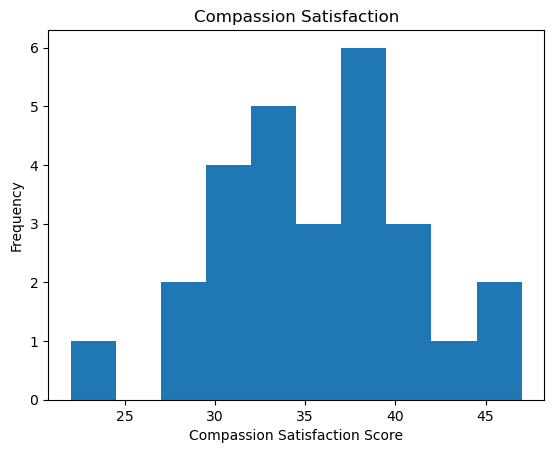

In [10]:
score_summary['Compassion Satisfaction'].plot(kind='hist', bins=10, title='Compassion Satisfaction')
plt.xlabel('Compassion Satisfaction Score')

Text(0.5, 0, 'Burnout Score')

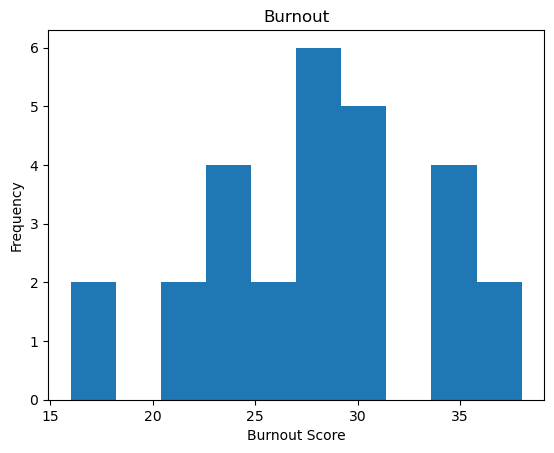

In [11]:
score_summary['Burnout'].plot(kind='hist', bins=10, title='Burnout')
plt.xlabel('Burnout Score')

Text(0.5, 0, 'STS Score')

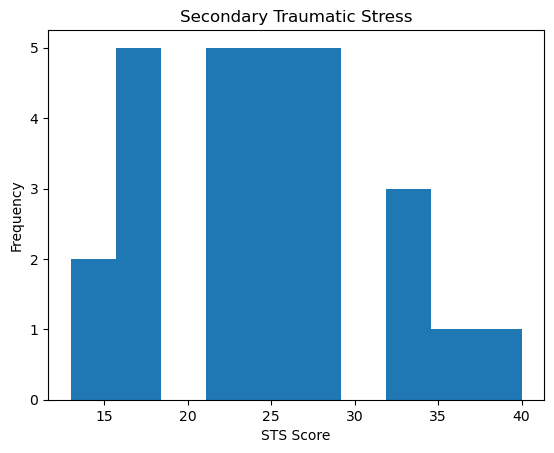

In [12]:
score_summary['Secondary Traumatic Stress'].plot(kind='hist', bins=10, title='Secondary Traumatic Stress')
plt.xlabel('STS Score')

According to the PROQOL documentation, the scores are broken down into low (22 or less), moderate (23 to 41), and high (42 and above) levels of compassion satisfaction, burnout, and secondary truamatic stress. It's also worth noting that these scores are relative to other people who work in helping professions. So let's go ahead and bin these scores a bit more appopriately.

In [13]:
# Create bins and counts for each score
bins=[0,23,42,50]
c_count=[]
b_count=[]
s_count=[]

# For each bin, count the number of observations in that bin range and append to the apropriate list.
for n in range(0,len(bins)-1):
    bcount=score_summary['Burnout'][(score_summary['Burnout']>bins[n]) & (score_summary['Burnout']<bins[n+1])].count()
    ccount=score_summary['Compassion Satisfaction'][(score_summary['Compassion Satisfaction']>bins[n]) & (score_summary['Compassion Satisfaction']<bins[n+1])].count()
    scount=score_summary['Secondary Traumatic Stress'][(score_summary['Secondary Traumatic Stress']>bins[n]) & (score_summary['Secondary Traumatic Stress']<bins[n+1])].count()
    
    c_count.append(ccount)
    b_count.append(bcount)
    s_count.append(scount)

In [14]:
# Turn lists into Series in order to more easily create a bar chart.
score_label=["Low", "Moderate", "High"]
c_series=pd.Series(data=c_count, index=score_label)
b_series=pd.Series(data=b_count, index=score_label)
s_series=pd.Series(data=s_count, index=score_label)

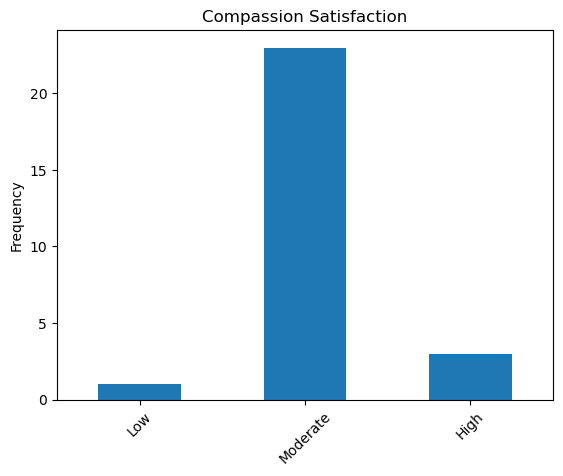

In [15]:
# Plot series as bar chart
c_series.plot(kind='bar')
# Add title and axis labels
plt.title('Compassion Satisfaction')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Display the plot
plt.show()

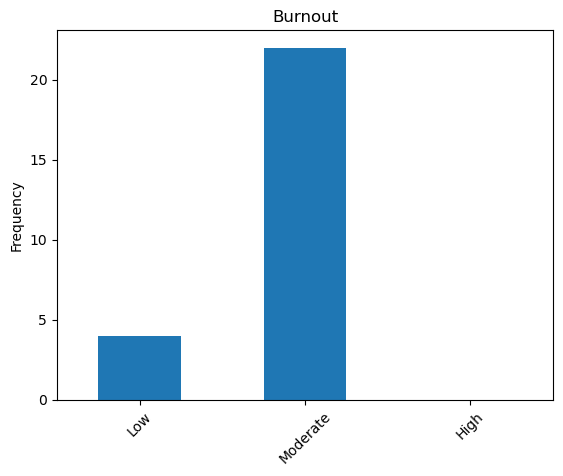

In [16]:
# Plot series as bar chart
b_series.plot(kind='bar')
# Add title and axis labels
plt.title('Burnout')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Display the plot
plt.show()

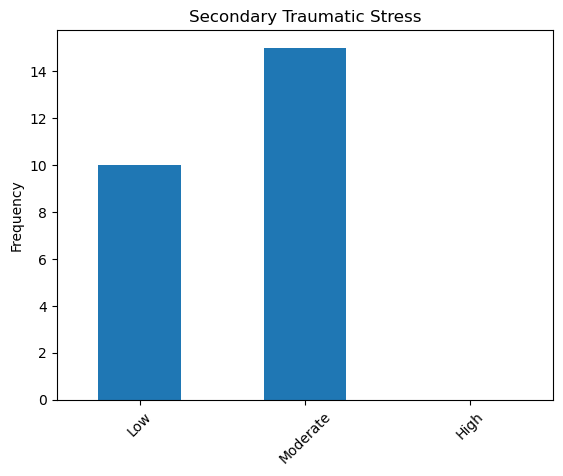

In [17]:
# Plot series as bar chart
s_series.plot(kind='bar')
# Add title and axis labels
plt.title('Secondary Traumatic Stress')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Display the plot
plt.show()

One thing we can take note of is that the vast majority of respondents are experiencing moderate burnout, while a noticeable majority is experiencing moderate secondary traumatic stress. On the other hand, almost all respondents are experiencing at least moderate compassion satisfaction. Now we should dig into the relationship between these variables. One thing to note is that burnout and secondary traumatic stress are supposed to capture compassion fatigue, which suggests that burnout and secondary traumatic stress may be predictive of compassion satisfaction.

In [49]:
''' 
Takes a one dimensional dataframe of predictors x, and values y, as well as optional parameters for 
names of x and y axes as inputs. The function then performs a simple linear regression with x and y,
and creates a scatter plot with line of best fit.
'''
def scatter_lin(x, y, x_name="x", y_name="y"):
    lreg=LinearRegression()
    lreg.fit(x, y)
    
    # Collect standard deviations to recover correlation coefficient later.
    s_x=np.std(x.values)
    s_y=np.std(y)
    # Slope and intercept of the regression line as well as the R^2
    beta_1=lreg.coef_[0]
    beta_0=lreg.intercept_
    rsquare=lreg.score(x,y)
    
    # Create a scatter plot of the data along with the line of best fit
    x_test=np.linspace(min(x.values),max(x.values))
    y_pred=beta_0+x_test*beta_1
    plt.scatter(x.values, y)
    plt.plot(x_test, y_pred, color='black')
    
    # label plot appropriately and print r, intercept, and slope
    plt.title(f'{x_name} vs {y_name}')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show
    print(f'r={(s_x/s_y)*beta_1}, beta_0={beta_0}, and beta_1={beta_1}')
    

r=-0.22545407877688373, beta_0=40.150695227358135, and beta_1=-0.19165727170236746


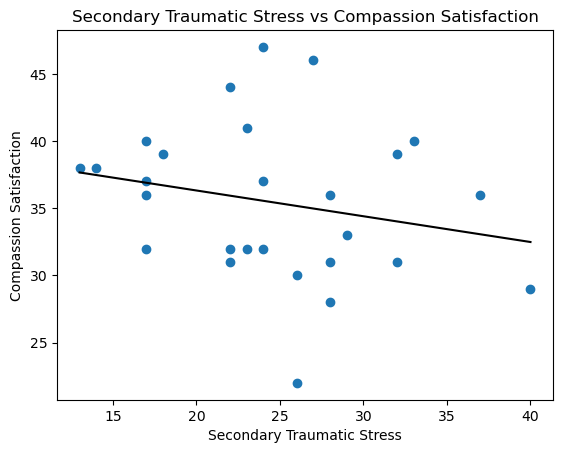

In [50]:
x_name='Secondary Traumatic Stress'
y_name='Compassion Satisfaction'
scatter_lin(score_summary[[x_name]], score_summary[y_name], x_name, y_name)


r=-0.4660644158440211, beta_0=48.80963822649379, and beta_1=-0.47669779671774415


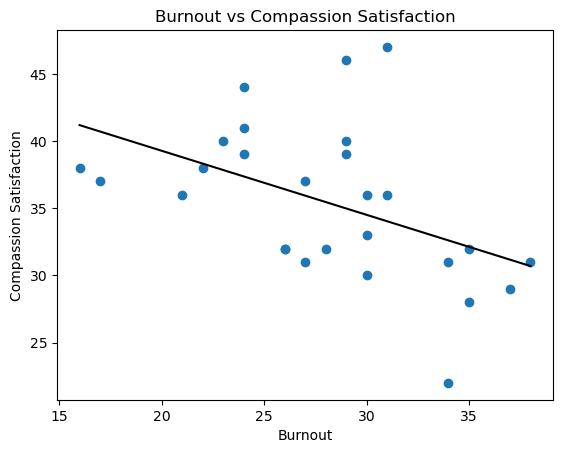

In [51]:
x_name='Burnout'
y_name='Compassion Satisfaction'
scatter_lin(score_summary[[x_name]], score_summary[y_name], x_name, y_name)
